In [1]:
import faiss
import Levenshtein
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn.functional as F
from datasets import load_dataset, load_from_disk
from faiss import read_index, write_index
from matplotlib import pyplot as plt
from sentence_transformers import SentenceTransformer

sns.set()
%matplotlib inline

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [16]:
# https://www.kaggle.com/code/philippsinger/h2ogpt-perplexity-ranking
def precision_at_k(r, k):
    """Precision at k"""
    assert k <= len(r)
    assert k != 0
    return sum(int(x) for x in r[:k]) / k


def map_k(true_items, predictions, K=3):
    """Score is mean average precision at 3"""
    U = len(predictions)
    map_at_k = 0.0
    for u in range(U):
        user_preds = predictions[u]
        user_true = true_items[u]
        user_results = [1 if item == user_true else 0 for item in user_preds]
        for k in range(min(len(user_preds), K)):
            map_at_k += precision_at_k(user_results, k + 1) * user_results[k]
    return map_at_k / U


def predictions_to_map_output(predictions):
    sorted_answer_indices = np.argsort(-predictions)  # Sortting indices in descending order
    top_answer_indices = sorted_answer_indices[:, :]  # Taking the first three indices for each row
    top_answers = np.vectorize(index_to_option.get)(
        top_answer_indices
    )  # Transforming indices to options - i.e., 0 --> A
    return np.apply_along_axis(lambda row: " ".join(row), 1, top_answers)

In [21]:
"""
df = pd.read_csv("../preprocessed/332_tfidf/000/val_500_enhanced.csv")
max_prob = np.load("../output/650_max/110/data4_pred.npy")
"""

df = pd.read_csv("../preprocessed/334_tfidf_gpu/000/data2.csv")
max_prob = np.load("../output/900_post_fts/000/data2_pred.npy")

In [22]:
miss_id = [
    13,
    28,
    39,
    65,
    201,
    205,
    207,
    213,
    217,
    226,
    228,
    245,
    251,
    254,
    258,
    260,
    262,
    270,
    278,
    284,
    286,
    296,
    308,
    312,
    314,
    338,
    347,
    373,
    389,
    413,
    417,
    420,
    422,
    430,
    438,
    440,
    444,
    445,
    454,
    465,
    467,
    478,
    486,
    491,
    494,
    507,
    508,
    509,
    515,
    530,
    531,
    550,
    569,
    574,
    586,
    593,
    612,
    631,
    641,
    646,
    647,
    648,
    656,
    659,
    666,
    667,
    668,
    669,
    670,
    676,
    677,
    689,
    690,
    696,
    698,
    699,
    705,
    716,
    735,
    748,
    771,
    773,
    779,
    795,
    802,
    803,
    804,
    806,
    828,
    840,
    841,
    843,
    854,
    856,
    860,
    864,
    874,
    884,
    905,
    914,
    916,
    921,
    928,
    938,
    950,
    957,
    961,
    965,
    971,
    974,
    975,
    979,
    981,
    995,
    1008,
    1009,
    1011,
    1018,
    1026,
    1055,
    1058,
    1061,
    1067,
    1078,
    1083,
    1125,
    1134,
    1143,
    1157,
    1159,
    1165,
    1180,
    1183,
    1185,
    1188,
    1194,
]
df["missed"] = False
df.loc[miss_id, "missed"] = True

In [23]:
"""
まずやりたいのは、secondに正解が来ているものがどれくらいあるのかを調べる必要がある
"""

first_prob = np.sort(max_prob)[:, -1]
second_prob = np.sort(max_prob)[:, -2]
third_prob = np.sort(max_prob)[:, -3]
prob_diff = first_prob - second_prob
df["first_prob"] = first_prob
df["second_prob"] = second_prob
df["third_prob"] = third_prob
df["prob_diff"] = prob_diff
df["prob_diff23"] = second_prob - third_prob

option_to_index = {option: idx for idx, option in enumerate("ABCDE")}
index_to_option = {v: k for k, v in option_to_index.items()}
first_option = np.argsort(max_prob)[:, -1]
df["first_option"] = first_option
df["first_option"] = df["first_option"].map(index_to_option)
second_option = np.argsort(max_prob)[:, -2]
df["second_option"] = second_option
df["second_option"] = df["second_option"].map(index_to_option)
third_option = np.argsort(max_prob)[:, -3]
df["third_option"] = third_option
df["third_option"] = df["third_option"].map(index_to_option)

df["first_len"] = 0
df["second_len"] = 0
df["third_len"] = 0
for i, row in df.iterrows():
    df.loc[i, "first_len"] = len(row[row["first_option"]])
    df.loc[i, "second_len"] = len(row[row["second_option"]])
    df.loc[i, "third_len"] = len(row[row["third_option"]])

# 正解がfirst, second, other のどれかを見る
df["answer_location"] = "other"
df.loc[df["first_option"] == df["answer"], "answer_location"] = "first"
df.loc[df["second_option"] == df["answer"], "answer_location"] = "second"
df.loc[df["third_option"] == df["answer"], "answer_location"] = "third"

df[df["missed"]].head(10)

,prompt,A,B,C,D,E,answer,context,missed,first_prob,...,third_prob,prob_diff,prob_diff23,first_option,second_option,third_option,first_len,second_len,third_len,answer_location
13,What is the Roche limit?,The Roche limit is the distance at which tidal...,The Roche limit is the distance at which tidal...,The Roche limit is the distance at which tidal...,The Roche limit is the distance at which tidal...,The Roche limit is the distance at which tidal...,D,Roche lobe > Roche lobe > The Roche lobe is di...,True,0.935325,...,0.000900,0.100977,0.833448,E,D,C,302,183,160,second
28,What is the evidence for the existence of a su...,The Milky Way galaxy has a supermassive black ...,The Milky Way galaxy has a supermassive black ...,The Milky Way galaxy has a supermassive black ...,The Milky Way galaxy has a supermassive black ...,The star S2 follows an elliptical orbit with a...,E,Supermassive black hole > Evidence > From the ...,True,0.740287,...,0.061274,0.186392,0.492621,B,E,D,662,587,242,second
39,What is the synapstor or synapse transistor?,A device used to demonstrate a neuro-inspired ...,A device used to demonstrate a neuro-inspired ...,A device used to demonstrate a neuro-inspired ...,A device used to demonstrate a neuro-inspired ...,A device used to demonstrate a neuro-inspired ...,E,"Memristor > Implementations > In July 2008, Er...",True,0.457426,...,0.259200,0.046802,0.151424,A,E,D,134,133,132,second
65,What is the relevant type of coherence for the...,Visibility,Coherence time,Spatial coherence,Coherence length,Diameter of the coherence area (Ac),E,Orders Of Coherence > Examples > Young double ...,True,0.999891,...,0.020956,0.757300,0.221634,C,E,B,17,35,14,second
201,What is the process of dissimilar friction sti...,Welding of different base metals using a rotat...,Melting of different base metals using a frict...,Melting and stirring together of different bas...,Joining different base metals using a friction...,Softening of different base metals using a fri...,D,Dissimilar friction stir welding > Dissimilar ...,True,0.957765,...,0.031789,0.673573,0.252403,E,D,A,170,102,107,second
205,What is the versatile characteristic of pyrido...,PLP binds to substrates in a non-covalent mann...,PLP acts as a reducing agent in redox reaction...,PLP stabilizes different types of carbanionic ...,PLP exhibits strong binding affinity towards m...,PLP is able to carry out more than 140 enzymat...,C,Aromatic L-amino acid decarboxylase > Mechanis...,True,0.991318,...,0.000338,0.883911,0.107070,E,C,B,121,118,94,second
207,What is the spectral type of Gliese 208?,M3,K4,K7,M0,M2,D,Gliese 208 > Gliese 208 > Gliese 208 (Gj 208) ...,True,0.919524,...,0.102329,0.317914,0.499282,C,D,A,2,2,2,second
213,What are salts and esters of caprylic acid kno...,Saturated fatty acid,Octanoates,Carboxylic acid,Octanoic acid,Caprylates,E,Caprylic acid > Caprylic acid > Caprylic acid ...,True,0.945309,...,0.000102,0.675688,0.269519,B,E,D,10,10,13,second
217,What is the main component of the lipopigments...,Nucleic acids,Proteins,Carbohydrates,Minerals,Lipids,B,Neuronal ceroid lipofuscinosis > Neuronal cero...,True,0.981499,...,0.011301,0.677940,0.292258,E,B,A,6,8,13,second
226,What is the significance of aquaglyceroporins?,Aquaglyceroporins are proteins found exclusive...,Aquaglyceroporins are proteins that are widely...,Aquaglyceroporins are proteins that are predom...,Aquaglyceroporins are proteins that are unique...,Aquaglyceroporins are proteins that conduct wa...,E,Aquaglyceroporins > Aquaglyceroporins > Aquagl...,True,0.990507,...,0.031919,0.910541,0.048047,B,E,D,139,191,166,second


<Axes: xlabel='prob_diff', ylabel='Count'>

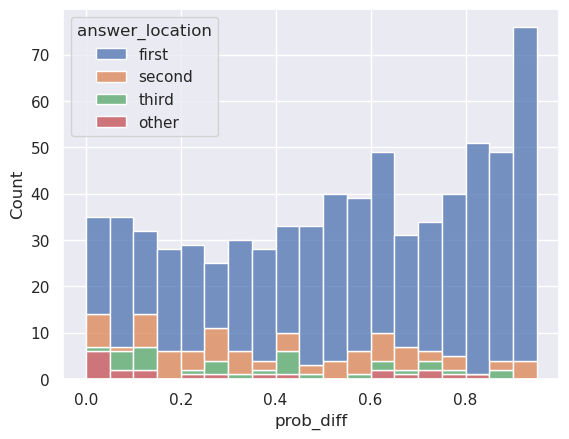

In [24]:
condition = df["prob_diff"] < 0.95

tmp_df = df.loc[condition]
sns.histplot(data=tmp_df, x="prob_diff", hue="answer_location", multiple="stack", binwidth=0.05)

<Axes: xlabel='prob_diff', ylabel='Count'>

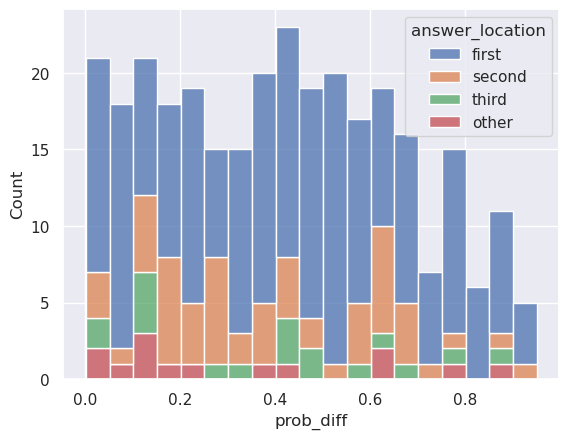

In [33]:
condition = (0.05 <= df["prob_diff23"]) & (0.0 < df["first_prob"]) & (df["first_prob"] < 0.99)

tmp_df = df.loc[condition]
sns.histplot(data=tmp_df, x="prob_diff", hue="answer_location", multiple="stack", binwidth=0.05)

In [34]:
map_k(df["answer"].to_numpy(), predictions_to_map_output(max_prob))

0.9105555555555563

In [35]:
"""
後処理に使えそうな特徴量を追加
"""


from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from tqdm.auto import tqdm

stop_words = list(stopwords.words("english"))


def get_tfidf(row: dict[str, str]) -> np.ndarray:
    """
    tfidfを計算する
    """
    # tfidfの計算
    tfidf = TfidfVectorizer(ngram_range=(3, 7), token_pattern=r"(?u)\b[\w/.-]+\b|!|/|\?|\"|\'", stop_words=stop_words)
    base_cols = ["A", "B", "C", "D", "E"]
    fit_cols = base_cols + ["context", "prompt"]
    tfidf_vec = tfidf.fit([row[col] for col in fit_cols])
    # base_cols と context の 類似度を計算
    base_vec = tfidf_vec.transform([row[col] for col in base_cols])
    context_vec = tfidf_vec.transform([row["context"]])
    sim = cosine_similarity(base_vec, context_vec)
    return sim


print("tfidfを計算")
tfidf_array = []
for _, row in tqdm(df.iterrows(), total=len(df)):
    tfidf_array.append(get_tfidf(row))
tfidf_array = np.array(tfidf_array).squeeze()
print(f"tfidf_array:{tfidf_array.shape}")

tfidfを計算


  0%|          | 0/1200 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'"] not in stop_words.
  warnings.warn(


tfidf_array:(1200, 5)


In [39]:
tfidf_array[39]

array([0.00294877, 0.00503183, 0.00271727, 0.00293583, 0.00505326])

0.8705555555555565

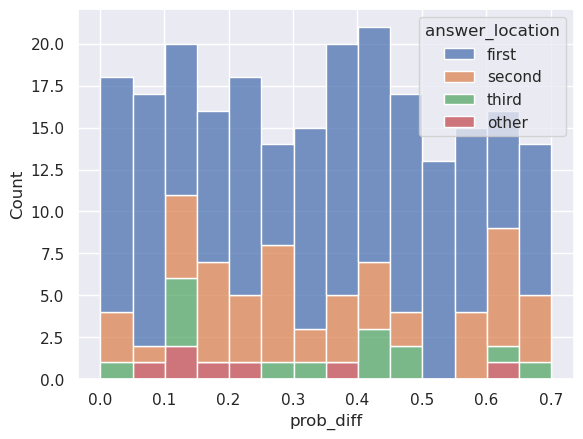

In [38]:
condition = (0.1 <= df["prob_diff23"]) & (0.0 < df["first_prob"]) & (df["first_prob"] < 0.99) & (df["prob_diff"] < 0.7)

tmp_df = df.loc[condition]
sns.histplot(data=tmp_df, x="prob_diff", hue="answer_location", multiple="stack", binwidth=0.05)

new_prob = max_prob.copy()
new_prob[condition] = new_prob[condition] * tfidf_array[condition]
map_k(df["answer"].to_numpy(), predictions_to_map_output(new_prob))

In [188]:
"""
後処理に使えそうな特徴量を追加
"""

model = SentenceTransformer("intfloat/multilingual-e5-small", device="cuda")
model.max_seq_length = "512"
model.half()


def get_sim(row: dict[str, str]) -> np.ndarray:
    """
    tfidfを計算する
    """
    # tfidfの計算
    tfidf = TfidfVectorizer()
    base_cols = ["A", "B", "C", "D", "E"]
    fit_cols = base_cols + ["prompt"]
    tfidf_vec = tfidf.fit([row[col] for col in fit_cols])
    # base_cols と context の 類似度を計算
    base_vec = tfidf_vec.transform([row[col] for col in base_cols])
    context_vec = tfidf_vec.transform([row["context"]])
    sim = cosine_similarity(base_vec, context_vec)
    return sim


print("tfidfを計算")
tfidf_array = []
for _, row in tqdm(df.iterrows(), total=len(df)):
    tfidf_array.append(get_tfidf(row))
tfidf_array = np.array(tfidf_array).squeeze()
print(f"tfidf_array:{tfidf_array.shape}")

0.9105555555555563

In [12]:
df = pd.read_csv("../preprocessed/332_tfidf/000/data2.csv")
a2 = np.load("../output/350_1st_infer/tfidf_gpu/data2_pred.npy")
max_prob = np.load("../output/600_max_ignore/200/data2_pred.npy")

In [13]:
index = 509
print(a2[index])
print(max_prob[index])
print("【Prompt】 ", df.iloc[index]["prompt"])
answer = df.iloc[index]["answer"]
print(f"【Answer {answer}】 ", df.iloc[index][df.iloc[index]["answer"]])
option_to_index = {option: idx for idx, option in enumerate("ABCDE")}
index_to_option = {v: k for k, v in option_to_index.items()}
max_prob_option = index_to_option[np.argmax(max_prob[index])]
print(f"【Wrong  {max_prob_option}】 ", df.iloc[index][max_prob_option])
print("【Context】 ", df.iloc[index]["context"])

[0.15962715 0.18302664 0.1316222  0.20120531 0.32451868]
[4.8315662e-05 2.7991712e-04 9.9999738e-01 3.7241494e-05 9.2069218e-05]
【Prompt】  What is the approximate distance of NGC 7129 from Earth?
【Answer D】  3.3 light years
【Wrong  C】  3,300 kilometers
【Context】  NGC 1052-DF2 > Distance > Follow-up observations using Hubble Space Telescope Advanced Camera for Surveys imaging measured the tip of the red-giant branch distance to NGC 1052-DF2, which IAC researchers detected at 13 Mpc, to be 22.1±1.2 Mpc, consistent with earlier surface brightness fluctuation measurements. The distance to NGC 1052-DF2 and its consequences for interpreting observations of the galaxy remain disputed. NGC 1090 > NGC 1090 > NGC 1090 is a barred spiral galaxy located in the constellation Cetus. NGC 1090 has a pseudo inner ring. The disc has a very low surface brightness. This galaxy has been the site of two known supernovae: SN 1962K and SN 1971T.NGC 1090 is not part of a galaxy group, even though it appears cl

In [25]:
df = pd.read_csv("../preprocessed/332_tfidf/000/val_500_enhanced.csv")
a2 = np.load("../output/370_1st_infer/tfidf/data4_pred.npy")
max_prob = np.load("../output/650_max/110/data4_pred.npy")

In [49]:
index = 507
print(a2[index])
print(max_prob[index])
print("【Prompt】 ", df.iloc[index]["prompt"])
answer = df.iloc[index]["answer"]
print(f"【Answer {answer}】 ", df.iloc[index][df.iloc[index]["answer"]])
option_to_index = {option: idx for idx, option in enumerate("ABCDE")}
index_to_option = {v: k for k, v in option_to_index.items()}
max_prob_option = index_to_option[np.argmax(max_prob[index])]
print(f"【Wrong  {max_prob_option}】 ", df.iloc[index][max_prob_option])
print("【Context】 ", df.iloc[index]["context"])

IndexError: index 507 is out of bounds for axis 0 with size 500

In [4]:
df = pd.read_parquet("../dataset/llm-science-filter-index/500_index/all-paraphs-parsed-expanded.parquet")

df.head()

,context
0,Russell Epstein > Russell Epstein > Russell Ep...
1,Russell Epstein > Education > Epstein received...
2,Ambient device > Ambient device > Ambient devi...
3,Ambient device > Purpose > The purpose of ambi...
4,Ambient device > History > The concept of ambi...


In [5]:
df["length"] = df.context.str.len()

<Axes: >

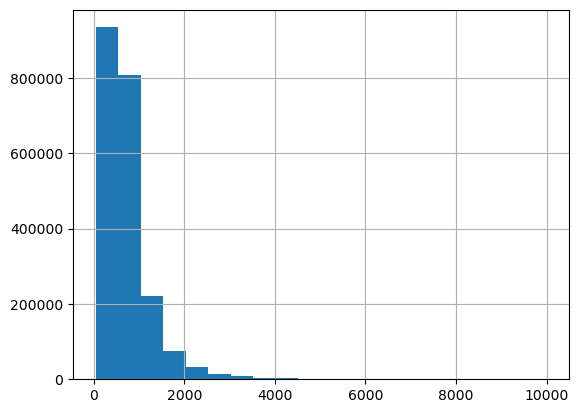

In [9]:
df.loc[df["length"] < 10000, "length"].hist(bins=20)

In [25]:
df = pd.read_csv("../preprocessed/332_tfidf/000/train.csv")

In [64]:
import re


def clean_prompt_answer(i):
    if "What is" in i.prompt:
        answer = ""
        answer = answer + i.prompt[7:-1] + " " + "is that" + " " + i.A
        answer = answer + i.prompt[7:-1] + " " + "is that" + " " + i.B
        answer = answer + i.prompt[7:-1] + " " + "is that" + " " + i.C
        answer = answer + i.prompt[7:-1] + " " + "is that" + " " + i.D
        answer = answer + i.prompt[7:-1] + " " + "is that" + " " + i.E
    elif "What was" in i.prompt:
        answer = ""
        answer = answer + i.prompt[8:-1] + " " + "was that" + " " + i.A
        answer = answer + i.prompt[8:-1] + " " + "was that" + " " + i.B
        answer = answer + i.prompt[8:-1] + " " + "was that" + " " + i.C
        answer = answer + i.prompt[8:-1] + " " + "was that" + " " + i.D
        answer = answer + i.prompt[8:-1] + " " + "was that" + " " + i.E
    elif "What are" in i.prompt:
        answer = ""
        answer = answer + i.prompt[8:-1] + " " + "are that" + " " + i.A
        answer = answer + i.prompt[8:-1] + " " + "are that" + " " + i.B
        answer = answer + i.prompt[8:-1] + " " + "are that" + " " + i.C
        answer = answer + i.prompt[8:-1] + " " + "are that" + " " + i.D
        answer = answer + i.prompt[8:-1] + " " + "are that" + " " + i.E
    elif "What were" in i.prompt:
        answer = ""
        answer = answer + i.prompt[9:-1] + " " + "were that" + " " + i.A
        answer = answer + i.prompt[9:-1] + " " + "were that" + " " + i.B
        answer = answer + i.prompt[9:-1] + " " + "were that" + " " + i.C
        answer = answer + i.prompt[9:-1] + " " + "were that" + " " + i.D
        answer = answer + i.prompt[9:-1] + " " + "were that" + " " + i.E
    elif "Which of the following statements" in i.prompt:
        answer = ""
        answer = i.prompt.replace("Which of the following statements ", "This ") + " ".join([i.A, i.B, i.C, i.D, i.E])
        answer = answer.replace("?", ". ")
    elif "Which of the following is" in i.prompt:
        answer = ""
        answer = i.prompt.replace("Which of the following is ", "This is ") + " ".join([i.A, i.B, i.C, i.D, i.E])
        answer = answer.replace("?", ". ")
    elif "What did " in i.prompt:
        answer = ""
        answer = i.prompt.replace("What did ", "") + " ".join([i.A, i.B, i.C, i.D, i.E])
        answer = answer.replace("?", ". ")
    elif "How do " in i.prompt:
        answer = ""
        answer = i.prompt.replace("How do ", "") + " ".join([i.A, i.B, i.C, i.D, i.E])
        answer = answer.replace("?", ". ")
    elif "How did " in i.prompt:
        answer = ""
        answer = i.prompt.replace("How did ", "") + " ".join([i.A, i.B, i.C, i.D, i.E])
        answer = answer.replace("?", ". ")
    else:
        pattern = r"Which (\w+ \w+ \w+|\w+ \w+|\w+) is"
        replacement = r"This \1 is"
        result = re.sub(pattern, replacement, i.prompt)
        if result != i.prompt:
            answer = result + " ".join([i.A, i.B, i.C, i.D, i.E])
            answer = answer.replace("?", ". ")
        else:
            answer = i.prompt + " " + " ".join([i.A, i.B, i.C, i.D, i.E])
    return answer

In [65]:
row = df.iloc[31]
clean_prompt_answer(row)

'This mathematical function is commonly used to characterize linear time-invariant systems. Trigonometric function Quadratic function Exponential function Logarithmic function Transfer function'

In [3]:
paraphs_parsed_dataset = load_from_disk("../input/all-paraphs-parsed-expanded")

In [4]:
df = pd.DataFrame(paraphs_parsed_dataset)

In [5]:
df.shape

(2101279, 3)

In [7]:
df["length"] = df["text"].apply(lambda x: len(x.split()))

In [16]:
import blingfire as bf
from pandarallel import pandarallel

pandarallel.initialize(progress_bar=True)


def extract_chunk_by_sliding_window(text: str, window_size: int, sliding_size: int) -> list[str]:
    """
    text のリストをsliding windowで結合する。window_size個のtextが含まれるまで結合し、sliding_size個ずつずらして結合する。
    """
    _, sentence_offsets = bf.text_to_sentences_and_offsets(text)
    text_list = []
    for o in sentence_offsets:
        if 3 < o[1] - o[0]:
            text_list.append(text[o[0] : o[1]])

    chunks = []
    for i in range(0, len(text_list), sliding_size):
        chunk = " ".join(text_list[i : i + window_size])
        chunks.append(chunk)
    return chunks


df["text"] = df["text"].parallel_apply(lambda x: extract_chunk_by_sliding_window(x, 4, 2))

INFO: Pandarallel will run on 12 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [17]:
explode_df = df.explode(["text"]).reset_index(drop=True)

<Axes: >

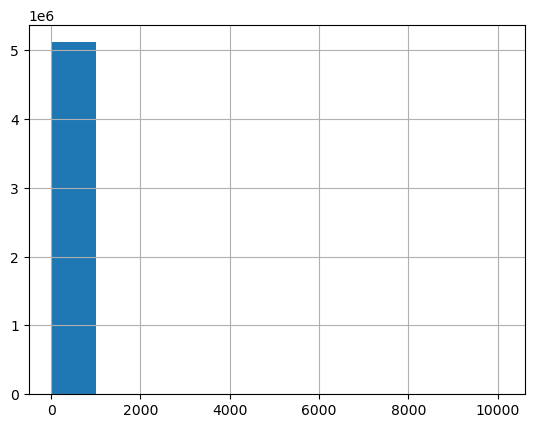

In [19]:
explode_df["length"] = explode_df["text"].apply(lambda x: len(x.split()))

<Axes: >

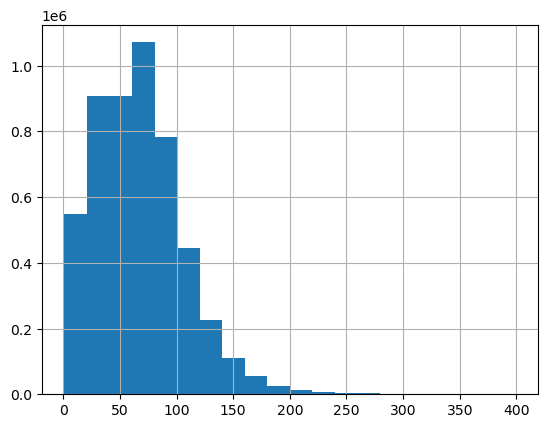

In [23]:
explode_df.loc[explode_df["length"] < 400, "length"].hist(bins=20)

In [5]:
df = pd.read_csv("../preprocessed/332_tfidf/000/train.csv")
a2 = np.load("../output/350_1st_infer/tfidf/data2_pred.npy")
df.iloc[96]

id                                                        96
prompt     Who proposed the concept of "maximal accelerat...
A                                                 Max Planck
B                                                 Niels Bohr
C                                      Eduardo R. Caianiello
D                                              Hideki Yukawa
E                                            Albert Einstein
answer                                                     C
context    Born reciprocity > Born reciprocity > However ...
Name: 96, dtype: object

In [6]:
a2[96]

array([1.5772917e-05, 1.5759566e-05, 9.9985933e-01, 9.4334922e-05,
       1.4752143e-05], dtype=float32)

In [4]:
df.iloc[96].context

'Born reciprocity > Born reciprocity > However Born\'s idea of a quantum metric operator was later taken up by Hideki Yukawa when developing his nonlocal quantum theory in the 1950s. In 1981, Eduardo R. Caianiello proposed a "maximal acceleration", similarly as there is a minimal length at Planck scale, and this concept of maximal acceleration has been expanded upon by others. It has also been suggested that Born reciprocity may be the underlying physical reason for the T-duality symmetry in string theory, and that Born reciprocity may be of relevance to developing a quantum geometry.Born chose the term "reciprocity" for the reason that in a crystal lattice, the motion of a particle can be described in p-space by means of the reciprocal lattice. Glossary of Lie groups and Lie algebras > M > maximal 1. For "maximal compact subgroup", see #compact. 2. For "maximal torus", see #torus. Laser > History > Laser In April 1957, Japanese engineer Jun-ichi Nishizawa proposed the concept of a "se

In [3]:
a1 = np.load("../test_predictions (2).npy")
a2 = np.load("../output/350_1st_infer/000/data2_pred.npy")

In [5]:
a1[0, :10]

array([5.0899638e-05, 1.6020971e-05, 2.6945649e-05, 9.9956685e-01,
       3.3927185e-04], dtype=float32)

In [6]:
a2[0, :10]

array([5.0899591e-05, 1.6021109e-05, 2.6945854e-05, 9.9956685e-01,
       3.3927124e-04], dtype=float32)

In [6]:
df = pd.read_parquet("../preprocessed/201_embedding/000/l.parquet")
sentence_embeddings = np.load("../preprocessed/201_embedding/000/l.npy").astype(np.float32, copy=False)

In [7]:
drop_idx = df["section_text"].str.startswith("Notes: &lt;")
sentence_embeddings = sentence_embeddings[~drop_idx]
df = df[~drop_idx].reset_index(drop=True)

In [8]:
df.shape, sentence_embeddings.shape

((1401590, 2), (1401590, 384))

In [9]:
df[df["id"] == "23473595"]

,id,section_text
1374970,23473595,Light-year: Distance that light travels in one...
1374971,23473595,"Definitions: As defined by the IAU, the light-..."
1374972,23473595,"Another value, , is the product of the J1900.0..."
1374973,23473595,History: The light-year unit appeared a few ye...
1374974,23473595,In 1868 an English journal labelled the light-...
1374975,23473595,Usage of term: Distances expressed in light-ye...
1374976,23473595,Related units: Distances between objects withi...


In [10]:
df[1374970:]

,id,section_text
1374970,23473595,Light-year: Distance that light travels in one...
1374971,23473595,"Definitions: As defined by the IAU, the light-..."
1374972,23473595,"Another value, , is the product of the J1900.0..."
1374973,23473595,History: The light-year unit appeared a few ye...
1374974,23473595,In 1868 an English journal labelled the light-...
...,...,...
1401585,24889426,Words taken directly from Latin and Ancient Gr...
1401586,24889426,List of English words with dual Old English/Ol...
1401587,24889718,Lefty (album): Lefty is the seventh solo studi...
1401588,24889826,List of United States federal courthouses in C...


In [11]:
train_df = pd.read_csv("../input/kaggle-llm-science-exam/train.csv")

train_df["answer_all"] = train_df.apply(lambda x: " ".join([x["A"], x["B"], x["C"], x["D"], x["E"]]), axis=1)
train_df["prompt_answer_stem"] = train_df["prompt"] + " " + train_df["answer_all"]

In [13]:
smodel = SentenceTransformer("BAAI/bge-small-en", device="cpu")
smodel.max_seq_length = 386
smodel.half()

SentenceTransformer(
  (0): Transformer({'max_seq_length': 386, 'do_lower_case': True}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': True, 'pooling_mode_mean_tokens': False, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
)

In [15]:
question_embeddings = smodel.encode(
    [train_df.iloc[49].prompt_answer_stem],
    batch_size=8,
    device="cuda",
    show_progress_bar=True,
    # convert_to_tensor=True,
    normalize_embeddings=True,
)


num_include = 5

prompt_index = faiss.index_factory(sentence_embeddings.shape[1], "Flat")
prompt_index.add(sentence_embeddings[1374970:])
ss, ii = prompt_index.search(question_embeddings.astype("float32"), num_include)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [16]:
ss

array([[0.08308185, 0.13949133, 0.16772568, 0.1909834 , 0.19430317]],
      dtype=float32)

In [17]:
sentence_embeddings[1374970:]

array([[-7.9574585e-03, -2.4795532e-02,  2.7060509e-05, ...,
        -9.7579956e-03, -2.5466919e-02,  5.9783936e-02],
       [-6.9824219e-02,  3.4046173e-03, -2.3681641e-02, ...,
        -9.3231201e-03,  2.1316528e-02,  5.8197021e-02],
       [-7.4096680e-02, -7.6026917e-03,  4.8942566e-03, ...,
        -2.3040771e-02,  5.7888031e-04,  4.5196533e-02],
       ...,
       [-3.2073975e-02, -1.2962341e-02,  3.4729004e-02, ...,
        -7.0739746e-02,  2.6275635e-02,  6.4025879e-02],
       [-2.2293091e-02, -3.6621094e-02,  1.4968872e-02, ...,
        -4.3182373e-03,  3.8238525e-02,  6.6833496e-02],
       [-5.4901123e-02, -6.7901611e-03, -1.9897461e-02, ...,
        -3.8166046e-03,  1.5182495e-02,  7.9772949e-02]], dtype=float32)

In [18]:
df.iloc[1374970 + ii[0, 0]].section_text

'Light-year: Distance that light travels in one year\nA light-year, alternatively spelled light year, is a large unit of length used to express astronomical distances and is equivalent to about 9.46\xa0trillion kilometers (), or 5.88\xa0trillion miles ().\nAs defined by the International Astronomical Union (IAU), a light-year is the distance that light travels in a vacuum in one Julian year (365.25 days).\nBecause it includes the time-measurement word "year", the term "light-year" is sometimes misinterpreted as a unit of time.\nThe "light-year" is most often used when expressing distances to stars and other distances on a galactic scale, especially in non-specialist contexts and popular science publications.\nThe unit most commonly used in professional astronomy is the parsec (symbol: pc, about 3.26 light-years) which derives from astrometry; it is the distance at which one astronomical unit (au) subtends an angle of one second of arc.'

In [44]:
df.iloc[1374970 + ii[0, 1]].section_text

'Related units: Distances between objects within a star system tend to be small fractions of a light-year, and are usually expressed in astronomical units.\nHowever, smaller units of length can similarly be formed usefully by multiplying units of time by the speed of light.\nFor example, the light-second, useful in astronomy, telecommunications and relativistic physics, is exactly metres or &lt;templatestyles src="Fraction/styles.css" /&gt;⁄ of a light-year.\nUnits such as the light-minute, light-hour and light-day are sometimes used in popular science publications.\nThe light-month, roughly one-twelfth of a light-year, is also used occasionally for approximate measures.\nThe Hayden Planetarium specifies the light month more precisely as 30 days of light travel time.\nLight travels approximately one foot in a nanosecond; the term "light-foot" is sometimes used as an informal measure of time.'